In [3]:
# Instalar paquetes necesarios
using Pkg
Pkg.add("DataFrames")
Pkg.add("GLM")
Pkg.add("Plots")
Pkg.add("Combinatorics")
Pkg.add("CSV")

# Cargar paquetes
using Random
using DataFrames
using GLM
using Plots
using Combinatorics
using CSV

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
Precompiling project...
┌ Warning: attempting to remove probably stale pidfile
│   path = "/root/.julia/compiled/v1.11/Reactant/p9PzF_MJWkB.ji.pidfile"
└ @ FileWatching.Pidfile /usr/local/share/julia/stdlib/v1.11/FileWatching/src/pidfile.jl:249
 314536.7 ms  ✓ Reactant
  12159.4 ms  ✓ Reactant → ReactantStatisticsExt
  12519.4 ms  ✓ Reactant → ReactantRandom123Ext
  13192.1 ms  ✓ Reactant → ReactantSparseArraysExt
  16763.5 ms  ✓ Reactant → ReactantKernelAbstractionsExt
  12353.3 ms  ✓ Reactant → ReactantFillArraysExt
  12058.2 ms  ✓ Reactant → ReactantSpecialFunctionsExt
  11900.1 ms  ✓ Reactant → ReactantAbstractFFTsExt
  10183.1 ms  ✓ Reactant → ReactantArrayInterfaceExt
  13341.0 ms  ✓ Reactant → ReactantOffsetArraysExt
  13085.6 ms  ✓ LuxCore → LuxCoreReactantExt
  12453.9 ms  ✓ MLDataDevices → MLDataDevicesReactantExt
  22533.3 ms

In [23]:
# Crear directorio de salida
OUT_DIR = "Julia_output_part3"
mkpath(OUT_DIR)

"Julia_output_part3"

In [24]:
Random.seed!(2025)

# Parámetros
n = 2000         # observaciones
n_sims = 200     # simulaciones para el plot comparativo
true_beta = 2.0  # efecto verdadero X -> Y

2.0

In [21]:
function simulate_data_image_dag(n::Int; z_affects_x::Bool=false)
    U1 = randn(n)
    U2 = randn(n)
    eps_x = randn(n)
    eps_y = randn(n)
    eps_z = randn(n)

    if !z_affects_x
        # Escenario inicial (imagen): Z no -> X
        X = 0.8 .* U1 .+ 0.4 .* randn(n) .+ eps_x
        Z = 0.6 .* U1 .+ 0.7 .* U2 .+ eps_z
    else
        # Escenario modificado: añadimos Z -> X
        Z = 0.6 .* U1 .+ 0.7 .* U2 .+ eps_z
        X = 0.8 .* U1 .+ 0.5 .* Z .+ eps_x
    end

    Y = true_beta .* X .+ 0.5 .* U1 .+ 0.6 .* U2 .+ eps_y

    return DataFrame(Y=Y, X=X, Z=Z, U1=U1, U2=U2)
end

"""
    run_comparison(; n_sims=200, n=2000, z_affects_x=false)

Ejecuta comparación entre modelos con y sin control por Z.
"""
function run_comparison(; n_sims::Int=200, n::Int=2000, z_affects_x::Bool=false)
    coef_no_z = Float64[]
    se_no_z = Float64[]
    coef_with_z = Float64[]
    se_with_z = Float64[]

    for i in 1:n_sims
        df = simulate_data_image_dag(n; z_affects_x=z_affects_x)

        # Modelo sin Z: Y ~ X
        m1 = lm(@formula(Y ~ X), df)
        push!(coef_no_z, coef(m1)[2])      # coeficiente de X
        push!(se_no_z, stderror(m1)[2])

        # Modelo con Z: Y ~ X + Z
        m2 = lm(@formula(Y ~ X + Z), df)
        push!(coef_with_z, coef(m2)[2])    # coeficiente de X
        push!(se_with_z, stderror(m2)[2])
    end

    return DataFrame(
        coef_no_z = coef_no_z,
        se_no_z = se_no_z,
        coef_with_z = coef_with_z,
        se_with_z = se_with_z
    )
end

run_comparison

In [26]:
println("Ejecutando simulaciones...")
res_base = run_comparison(n_sims=n_sims, n=n, z_affects_x=false)
println("Simulaciones completadas: $(nrow(res_base)) filas")

Ejecutando simulaciones...
Simulaciones completadas: 200 filas


### ===== GRÁFICO 1: Comparación de coeficientes =====

In [27]:
p = plot(size=(1000, 500),
    xlabel="Simulación",
    ylabel="Estimador de β (coef en X)",
    title="Estimates of β across simulations — con/sin control por Z (DAG imagen)",
    legend=:topright)

# Scatter plots
scatter!(p, 1:nrow(res_base), res_base.coef_no_z,
    alpha=0.45, label="coef (no Z)", markersize=3, color=:blue)
scatter!(p, 1:nrow(res_base), res_base.coef_with_z,
    alpha=0.6, label="coef (with Z)", markersize=3, color=:orange)

# Línea horizontal para true_beta
hline!(p, [true_beta], linestyle=:dash, linewidth=2,
    label="True β = $true_beta", color=:red)

plot_path = joinpath(OUT_DIR, "coef_plot_image_dag.png")
savefig(p, plot_path)
println("Saved: ", plot_path)

Saved: Julia_output_part3/coef_plot_image_dag.png


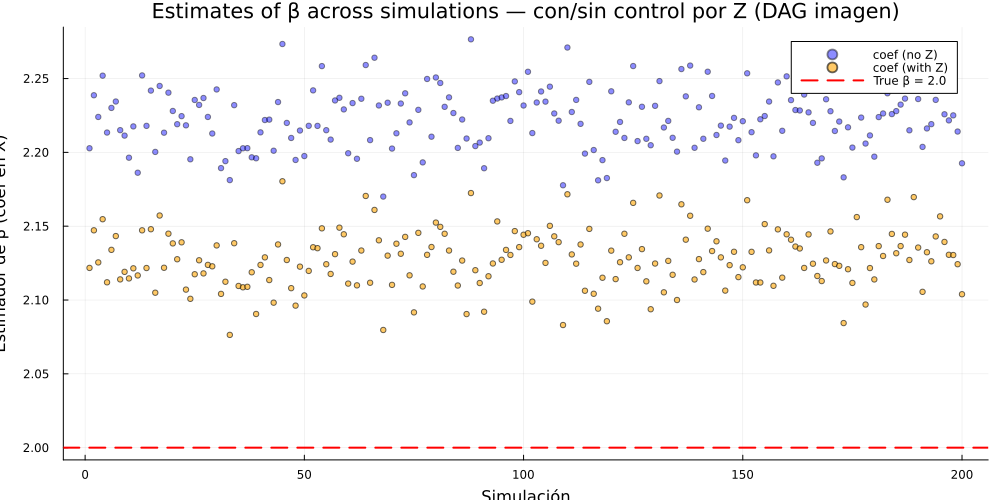

In [28]:
p

### ===== ANÁLISIS CON TODAS LAS COMBINACIONES DE CONTROLES =====

In [29]:
# Simular un dataset con Z -> X (escenario modificado)
df_mod = simulate_data_image_dag(n, z_affects_x=true)

controls = ["Z", "U1", "U2"]
combos = [[]]  # Empezar con subset vacío

# Generar todas las combinaciones
for r in 1:length(controls)
    append!(combos, collect(combinations(controls, r)))
end

# Ejecutar regresiones para cada combinación
results = DataFrame(controls=String[], β=Float64[], SE=Float64[])

for subset in combos
    # Construir fórmula dinámicamente
    X_vars = vcat(["X"], subset)
    formula_str = "Y ~ " * join(X_vars, " + ")

    # Convertir string a fórmula y ejecutar regresión
    formula_obj = eval(Meta.parse("@formula($formula_str)"))
    mod = lm(formula_obj, df_mod)

    # Guardar resultados
    control_str = isempty(subset) ? "(none)" : join(subset, ",")
    push!(results, (control_str, coef(mod)[2], stderror(mod)[2]))
end

# Ordenar por nombre de controles
sort!(results, :controls)

println("\n===== Resultados de regresiones =====")
println(results)


===== Resultados de regresiones =====
8×3 DataFrame
 Row │ controls  β        SE
     │ String    Float64  Float64
─────┼──────────────────────────────
   1 │ (none)    2.29407  0.0166766
   2 │ U1        2.13328  0.0225645
   3 │ U1,U2     1.99504  0.020454
   4 │ U2        2.22947  0.0154
   5 │ Z         2.10742  0.020671
   6 │ Z,U1      1.95905  0.024808
   7 │ Z,U1,U2   1.96529  0.022657
   8 │ Z,U2      2.16465  0.0198234


### ===== GRÁFICO 2: Error bars para todas las combinaciones =====


In [30]:
p2 = plot(size=(900, 500),
    ylabel="Estimate of β (coef on X)",
    title="Estimates (β) for all control combos — scenario Z→X (modified)",
    legend=:topright,
    bottom_margin=10Plots.mm)

# Error bars con intervalo de confianza 95%
scatter!(p2, 1:nrow(results), results.β,
    yerror=1.96 .* results.SE,
    label="", markersize=5, color=:blue)

# Línea de referencia
hline!(p2, [true_beta], linestyle=:dash, linewidth=2,
    label="True β = $true_beta", color=:red)

# Configurar etiquetas del eje X
plot!(p2, xticks=(1:nrow(results), results.controls),
    xrotation=45)

plot2_path = joinpath(OUT_DIR, "estimates_combo_plot_image_dag.png")
savefig(p2, plot2_path)
println("Saved: ", plot2_path)

Saved: Julia_output_part3/estimates_combo_plot_image_dag.png


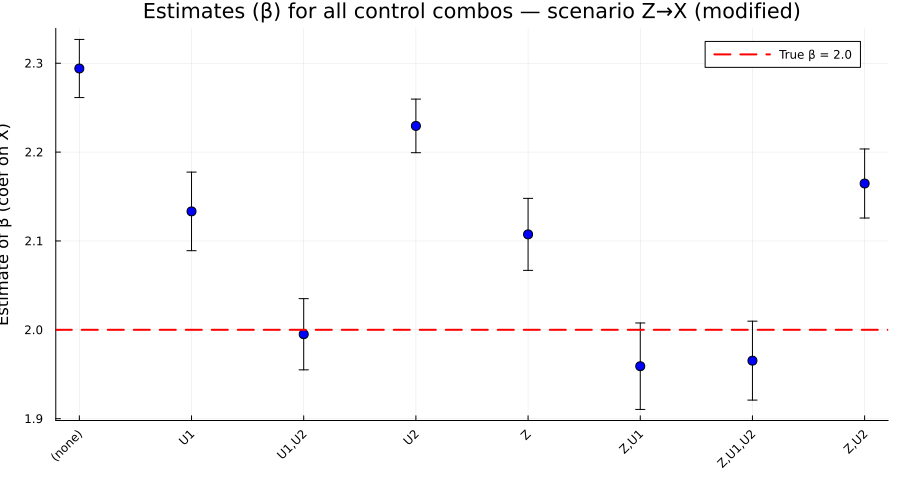

In [31]:
p2

### ===== CREAR DAG SIMPLE CON GRAPHPLOT =====

In [12]:
# Nota: Julia no tiene un equivalente directo a causalgraphicalmodels
# Usaremos GraphPlot.jl para visualización básica

using Pkg
Pkg.add("Graphs")
Pkg.add("GraphPlot")

using Graphs
using GraphPlot

# Crear grafo dirigido
g = DiGraph(5)
node_labels = ["U1", "U2", "Z", "X", "Y"]

# Añadir aristas según el DAG
edges_list = [
    (1, 4),  # U1 -> X
    (1, 3),  # U1 -> Z
    (2, 3),  # U2 -> Z
    (2, 5),  # U2 -> Y
    (3, 5),  # Z -> Y
    (4, 5)   # X -> Y
]

for (src, dst) in edges_list
    add_edge!(g, src, dst)
end

# Posiciones manuales para mejor visualización
locs_x = [-1.0, 1.0, 0.0, -1.0, 1.0]
locs_y = [1.0, 1.0, 1.0, -1.0, -1.0]

# Dibujar DAG
dag_plot = gplot(g, locs_x, locs_y,
    nodelabel=node_labels,
    NODESIZE=0.15,
    nodelabelsize=2.0,
    arrowlengthfrac=0.05)

# Guardar (requiere Compose.jl)
Pkg.add("Compose")
using Compose

dag_path = joinpath(OUT_DIR, "dag_image_simple.svg")
draw(SVG(dag_path, 16cm, 12cm), dag_plot)
println("Saved DAG: ", dag_path)

println("\n✓ Análisis completo finalizado")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
  [a81c6b42] + Compose v0.9.6
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


Saved DAG: Julia_output_part3/dag_image_simple.svg

✓ Análisis completo finalizado


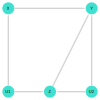

In [33]:
display(dag_plot)